In [0]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

## BinMNIST


In [0]:
import os
import pickle as pkl
from urllib.request import urlretrieve

import numpy as np
import torch
cuda = torch.cuda.is_available()
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

from torch.utils.data.sampler import SubsetRandomSampler
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: (x).view(-1, 28**2)


def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test

class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=flatten):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)

    return BinMNIST(x_train, device=device), BinMNIST(x_valid, device=device), BinMNIST(x_test, device=device)


batch_size = 64
# The loaders perform the actual work
root = "C:/Users/Zuzka/git/02456-deep-learning-with-PyTorch/7_Unsupervised"
dset_train, x_valid, dset_test = get_binmnist_datasets(root)

train_loader = DataLoader(dset_train, batch_size=batch_size, shuffle=True,
                          pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          pin_memory=cuda)

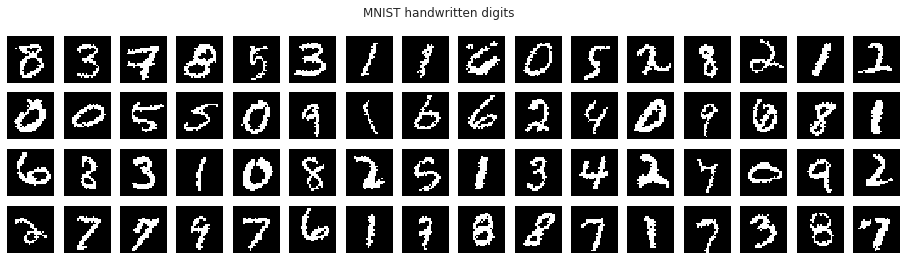

In [3]:
#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

### Building the model


In [4]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
num_features = 28**2
n_hidden = 256

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=n_hidden), # num_features=784
            nn.ReLU(),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.ReLU(),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean and variance
            nn.Linear(in_features=n_hidden, out_features=2*self.latent_features) # <- note the 2*latent_features
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=n_hidden),
            nn.ReLU(),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.ReLU(),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.ReLU(), 
            nn.Linear(in_features=n_hidden, out_features=num_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector
        x = x.reshape(-1, 784)
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        sigma = torch.exp(log_var/2)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)        
        
        # Run through decoder
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        
        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs


latent_features = 2
num_samples = 100

net = VariationalAutoencoder(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
  )
)


Following we define the PyTorch functions for training and evaluation.

In [0]:
from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum() 

# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

Test the forward pass, to check that everything is in order.

In [6]:
from torch.autograd import Variable

x = next(iter(train_loader))
x = Variable(x)

if cuda:
    x = x.cuda()

outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl = loss_function(x_hat, x, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

torch.Size([64, 1, 784])
torch.Size([64, 784])
torch.Size([64, 100, 2])
tensor(544.3776, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.3657, device='cuda:0', grad_fn=<SumBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([64, 1, 784])) that is different to the input size (torch.Size([64, 784])) is deprecated. Please ensure they have the same size.
  import sys


In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

No handles with labels found to put in legend.


torch.Size([64, 784])


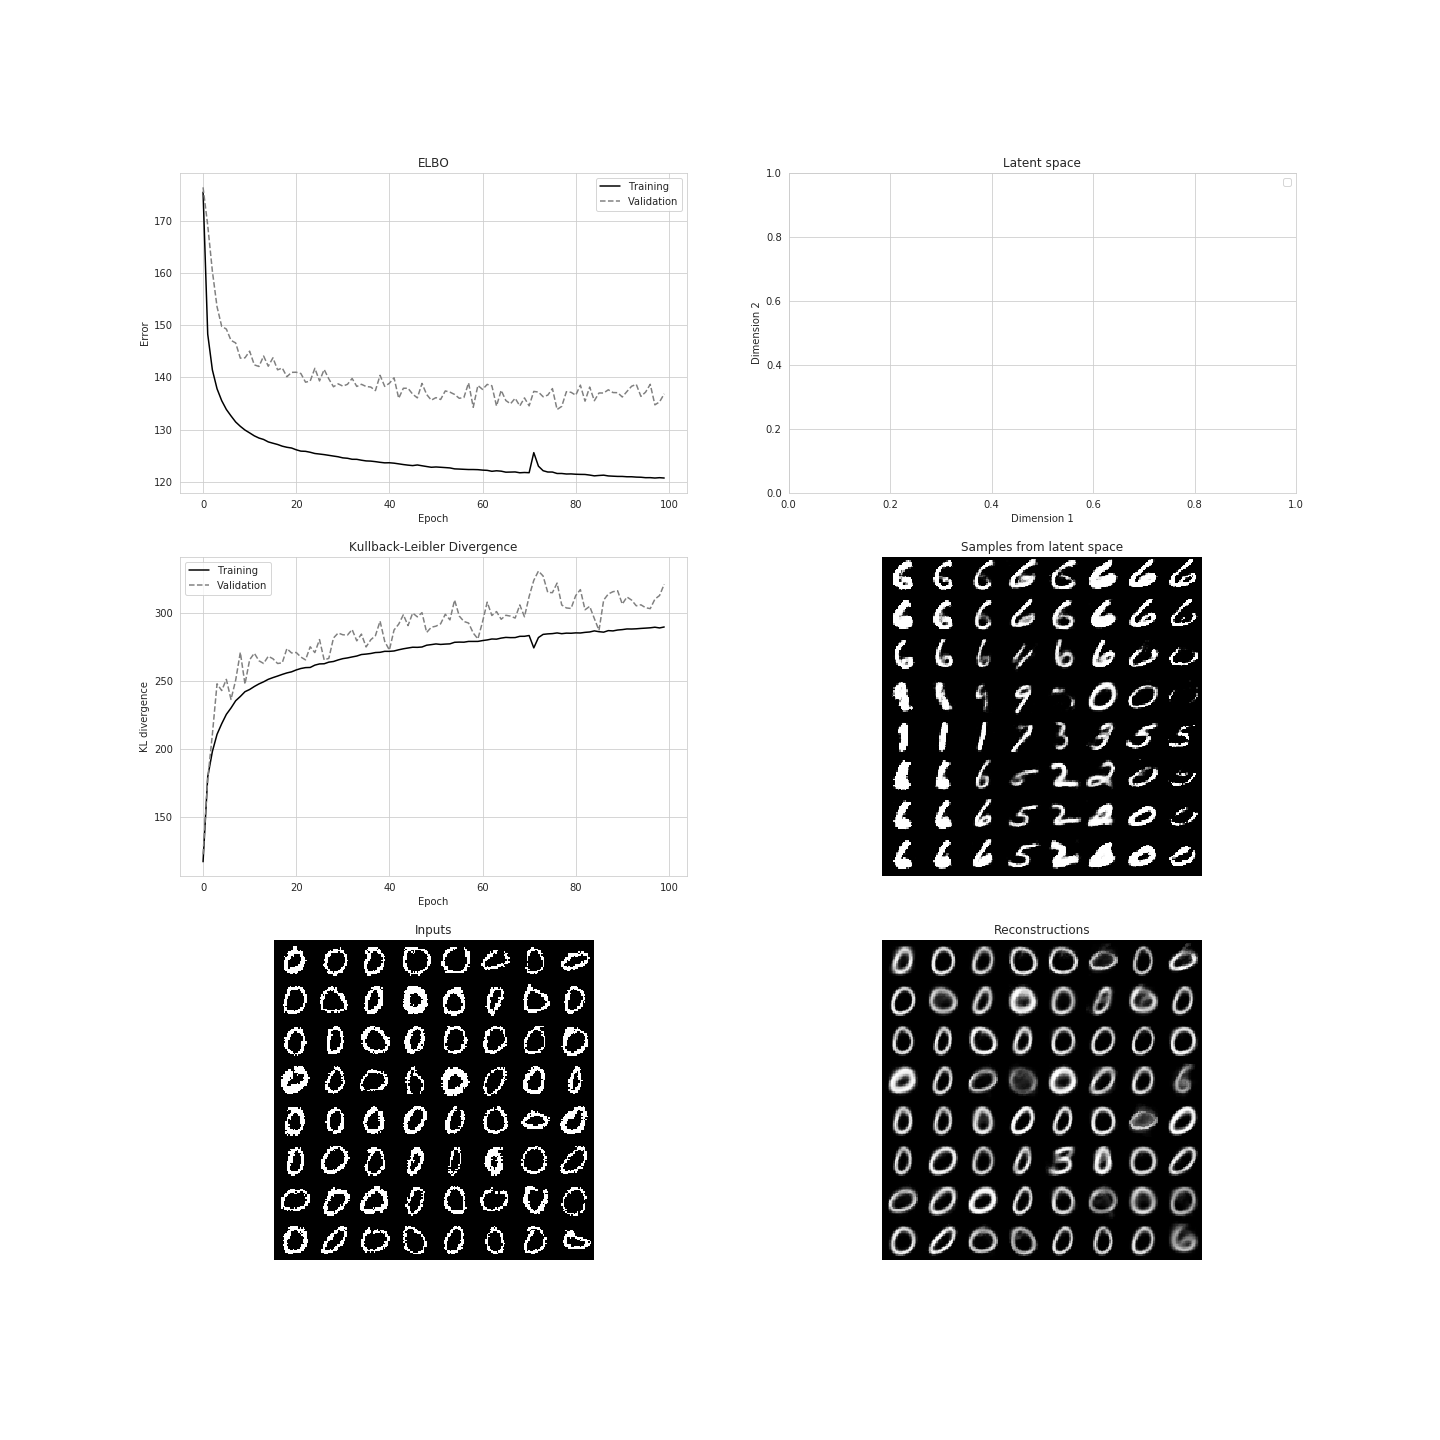

In [7]:
import os
from sklearn.decomposition import PCA

num_epochs = 100
tmp_img = "tmp_vae_out.png"
show_sampling_points = False

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for epoch in range(num_epochs):
    batch_loss, batch_kl = [], []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x in train_loader:
        x = Variable(x)
        # import pdb; pdb.set_trace()
        
        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        
        batch_loss.append(elbo.item())   
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x = next(iter(test_loader))
        x = Variable(x)
        
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
    
    if epoch == 0:
        continue
    
    # -- Plotting --
    f, axarr = plt.subplots(3, 2, figsize=(20, 20))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])

    # Latent space
    ax = axarr[0, 1]

    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    rows = 8
    columns = batch_size // rows
    
    span = np.linspace(-4, 4, rows)
    spans = latent_features * (span,)
    grid = np.dstack(np.meshgrid(*spans)).reshape(-1, latent_features)
    
    # If you want to use a dimensionality reduction method you can use
    # for example PCA by projecting on two principal dimensions
    # z = z.reshape(batch_size, -1)
    # z = PCA(n_components=2).fit_transform(z)

    # colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    #for c in classes:
     #   ax.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
    if show_sampling_points:
        ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

    ax.legend()
    
    # KL / reconstruction
    ax = axarr[1, 0]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black") 
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")  
    ax.legend(['Training', 'Validation'])
    
    # Latent space samples
    ax = axarr[1, 1]
    ax.set_title('Samples from latent space')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.from_numpy(grid).float().to(device)
        samples = torch.sigmoid(net.decoder(epsilon)).detach()
        print(samples.shape)

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Inputs
    ax = axarr[2, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
 
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[2, 1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_hat[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)